### Sanegene Bio qPCR Data Analysis 
#### by Pin Liu 09/03/2022

#### Before you use this analysis code, prepare the qPCR metadata using the "qPCR_metadata_generator_PL"
1. Save your qPCR raw data in excel format.
2. Delete any rows above and below the data table.
3. Decide the "Group" and "Treatment" parameters. For example, if the study has 2 compounds tested in 4 doses (i.e. 8 treatments) with 3 animals in each treatment and 5 tissues collected per animal, and you want to plot the qPCR result separately for different tissue types, you will want to have tissue type as the "Group", and compounds as the "Treatment".
4. Open the file named "qPCR_metadata_generator_PL", on the sheet named "Platemap_single parameter", input "Group", "Treatment", "Animal #", and "Technical Replicate". For empty wells, input "NaN". Then on the sheet named "Platemap_combined", you will get the combined metadata with 384-well layout. 
5. If you have two genes in your qPCR assay, the metadata you need for the qPCR analysis is automatically generated on the sheet named "Platemap_for_qPCR_2genes". If you have three genes in your qPCR assay, the metadata you need for the qPCR analysis is automatically generated on the sheet named "Platemap_for_qPCR_3genes".
6. Open the qPCR raw data file (.xlsx), copy the five columns ("Group", "Treatment", "Animal#", "TechRep", "Sample Name") and insert them into your qPCR raw data file.
7. Copy the qPCR raw data in xlsx format to the folder: C:/Users/pinli/Documents/qPCR Analysis/User folder

#### To run this code:
1. ONLY modify Six parameters in section 1!!!
2. In section 1, input (1) file name (2) ref_gene & its uplimit Ct value (3) target_gene & its uplimit Ct value (4) reference_group
3. Click "▶▶", then click "Restart and Run All Cells"
4. Results and figures can be found at: C:/Users/pinli/Documents/qPCR Analysis/User folder

#### Questions and comments: pliu@sanegenebio.com

In [14]:
# This is the path where analysis results are saved.
path = 'C:/Users/pinli/Documents/qPCR Analysis/User folder/'

# User to input file name
file = '2022-06-07 144752_21_EH_027_repeat_PL' + '.xlsx'

# User to indicate reference gene & its uplimit Ct value, target gene & its uplimit Ct value, and reference group
ref_gene = 'Rpl23'
ref_gene_uplimit = 40
target_gene = 'Sod1'
target_gene_uplimit = 40
reference_treatment = 'Cmpd1_3day_1nM'

In [27]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# df to store the raw data
qPCR_raw_data = pd.read_excel(path + file)
df = qPCR_raw_data

# get indexes of parameters needed for the analysis
sample_idx = df.columns.get_loc("SampleId")
well_idx = df.columns.get_loc("WellId")
target_idx = df.columns.get_loc("Target Name")
tissue_idx = df.columns.get_loc("Tissue")
group_idx = df.columns.get_loc("Group")
cmpd_idx = df.columns.get_loc("Compound")
dose_idx = df.columns.get_loc("Dose")
duration_idx = df.columns.get_loc("Duration")
treatment_idx = df.columns.get_loc("Treatment")
animal_idx = df.columns.get_loc("Animal#")
techRep_idx = df.columns.get_loc("TechRep")
ct_idx = df.columns.get_loc("CT")

# find out how many unique target genes and how many unique samples
unique_target = df.iloc[:, target_idx].unique()
unique_sample = df.iloc[:, sample_idx].unique()
num_sample = len(unique_sample)

In [16]:
# generate df2 with parameters needed for analysis; first calculate delta Ct of each well (Sample Name)
# then calculate expression (2.^-delta Ct)
j = 0
df2 = pd.DataFrame()
for k in range(num_sample):
    ref_rows = df.index[(df['SampleId'] == unique_sample[k]) & (df['Target Name'] == ref_gene)].tolist()
    target_rows = df.index[(df['SampleId'] == unique_sample[k]) & (df['Target Name'] == target_gene)].tolist()
    num_ref_rows = len(ref_rows)
    for i in range(num_ref_rows):
        df2.at[j, 'WellId'] = df.iloc[ref_rows[i], well_idx]
        df2.at[j, 'Tissue'] = df.iloc[ref_rows[i], tissue_idx]
        df2.at[j, 'Group'] = df.iloc[ref_rows[i], group_idx]
        df2.at[j, 'Compound'] = df.iloc[ref_rows[i], cmpd_idx]
        df2.at[j, 'Dose'] = df.iloc[ref_rows[i], dose_idx]
        df2.at[j, 'Duration'] = df.iloc[ref_rows[i], duration_idx]       
        df2.at[j, 'Treatment'] = df.iloc[ref_rows[i], treatment_idx]
        df2.at[j, 'Animal#'] = df.iloc[ref_rows[i], animal_idx]
        df2.at[j, 'TechRep'] = df.iloc[ref_rows[i], techRep_idx]
        df2.at[j, 'SampleId'] = df.iloc[ref_rows[i], sample_idx]
        df2.at[j, 'Reference'] = df.iloc[ref_rows[i], ct_idx]
        df2.at[j, 'Target'] = df.iloc[target_rows[i], ct_idx]
        if df2.at[j, 'Reference'] == 'Undetermined' or float(df2.at[j, 'Reference']) > ref_gene_uplimit or df2.at[j, 'Target'] == 'Undetermined' or float(df2.at[j, 'Target']) > target_gene_uplimit:
            df2.at[j, 'DeltaCt'] == 'NaN'
            df2.at[j, 'Expression 2^-DeltaCt'] == 'NaN'
        else:
            df2.at[j, 'DeltaCt'] = float(df2.at[j, 'Target']) - float(df2.at[j, 'Reference'])
            df2.at[j, 'Expression 2^-DeltaCt'] = pow(2, -(df2.at[j, 'DeltaCt']))
        j = j + 1

# remove samples with NaN value, and generate df3
df3 = df2.dropna()
df3 = df3.reset_index()

# find out how many unique samples after dropping all the samples with Nan
unique_sample_df3 = df3.SampleId.unique()
num_sample_df3 = len(unique_sample_df3)

# calculate average expression from technical replicates, generate df_prism for prism

for kk in range(num_sample_df3):    
    sample_rows = df3.index[df3.SampleId == unique_sample_df3[kk]].tolist()
    aveExpression = df3['Expression 2^-DeltaCt'].iloc[sample_rows].mean(axis=0)    
    for jj in (sample_rows):
        df3.at[jj, 'AvgExpression'] = aveExpression

df3.head(50)

,index,WellId,Tissue,Group,Compound,Dose,Duration,Treatment,Animal#,TechRep,SampleId,Reference,Target,DeltaCt,Expression 2^-DeltaCt,AvgExpression
0,0,A01,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#1,tech1,LSC_Cmpd1_3day_1nM_#1,21.425,20.794,-0.631,1.548638,1.883120
1,1,B01,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#1,tech2,LSC_Cmpd1_3day_1nM_#1,21.842,20.693,-1.149,2.217601,1.883120
2,2,A02,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#2,tech1,LSC_Cmpd1_3day_1nM_#2,22.141,21.177,-0.964,1.950711,2.004896
3,3,B02,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#2,tech2,LSC_Cmpd1_3day_1nM_#2,22.309,21.267,-1.042,2.059080,2.004896
4,4,A03,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#3,tech1,LSC_Cmpd1_3day_1nM_#3,21.713,21.187,-0.526,1.439931,1.389857
5,5,B03,LSC,G1,Cmpd1,1nM,3day,Cmpd1_3day_1nM,#3,tech2,LSC_Cmpd1_3day_1nM_#3,21.539,21.117,-0.422,1.339784,1.389857
6,6,A04,LSC,G9,Cmpd3,9nM,3day,Cmpd3_3day_9nM,#1,tech1,LSC_Cmpd3_3day_9nM_#1,21.631,26.089,4.458,0.045500,0.040232
7,7,B04,LSC,G9,Cmpd3,9nM,3day,Cmpd3_3day_9nM,#1,tech2,LSC_Cmpd3_3day_9nM_#1,21.852,26.69,4.838,0.034964,0.040232
8,8,A05,LSC,G9,Cmpd3,9nM,3day,Cmpd3_3day_9nM,#2,tech1,LSC_Cmpd3_3day_9nM_#2,21.15,27.187,6.037,0.015229,0.015542
9,9,B05,LSC,G9,Cmpd3,9nM,3day,Cmpd3_3day_9nM,#2,tech2,LSC_Cmpd3_3day_9nM_#2,21.418,27.397,5.979,0.015854,0.015542


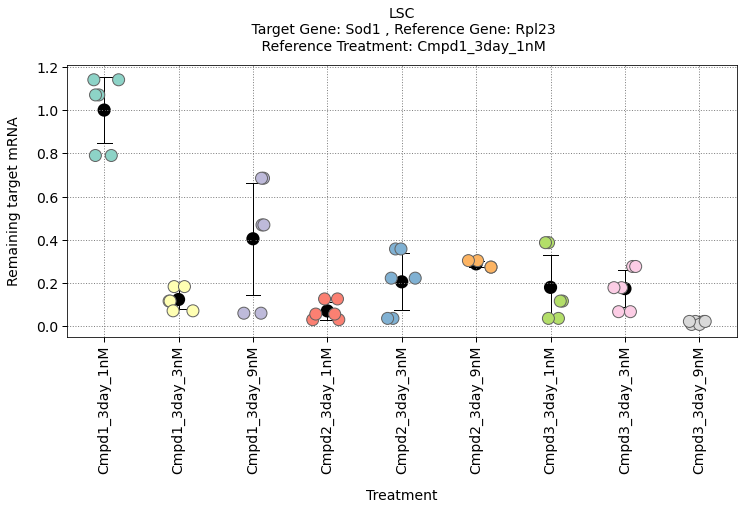

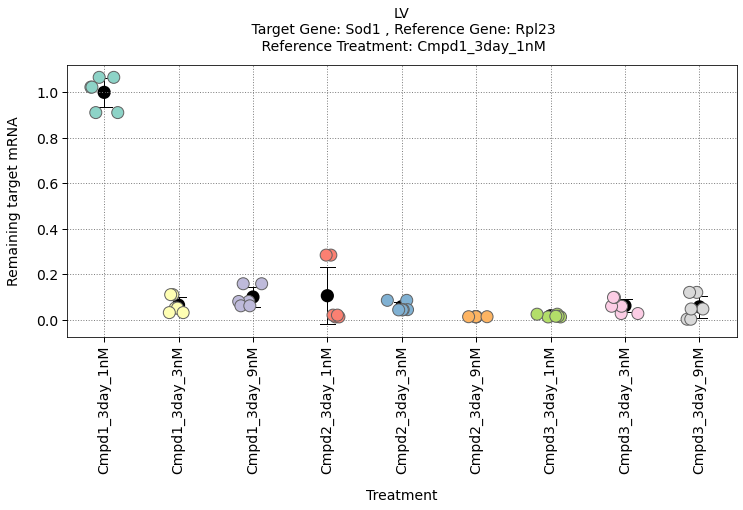

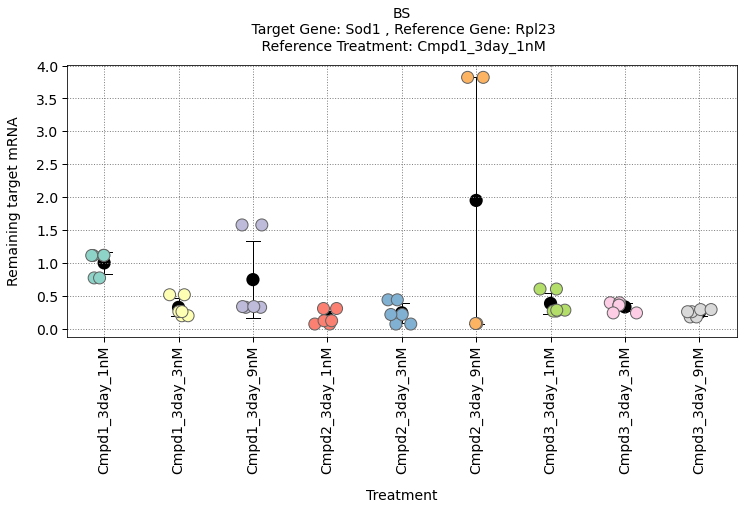

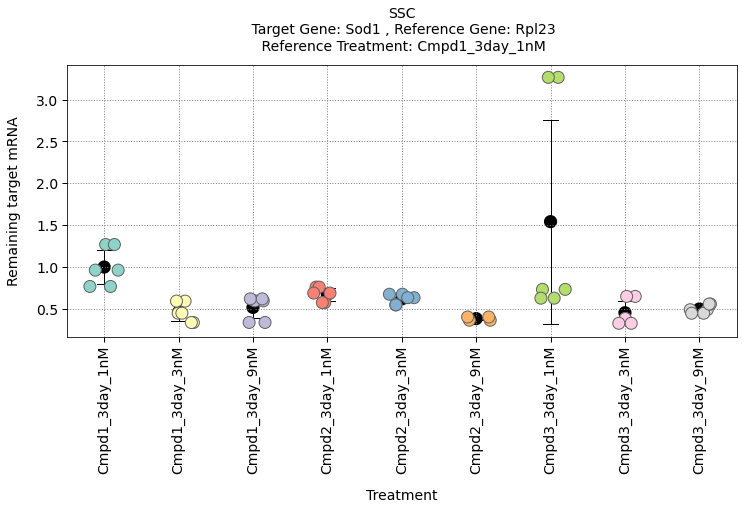

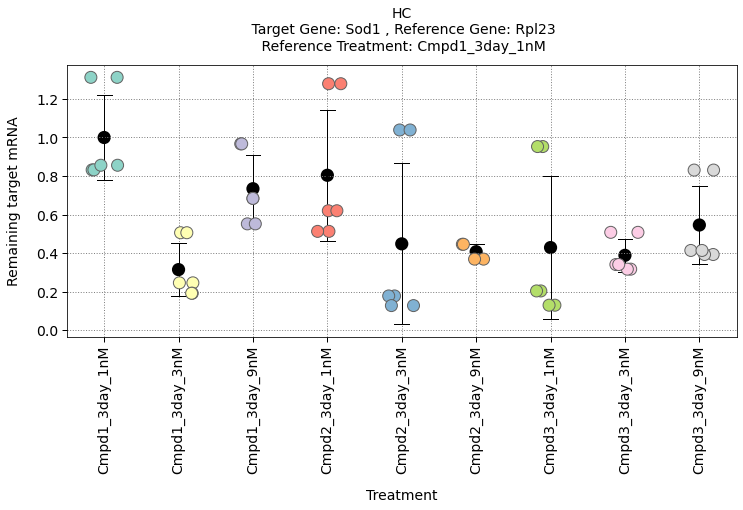

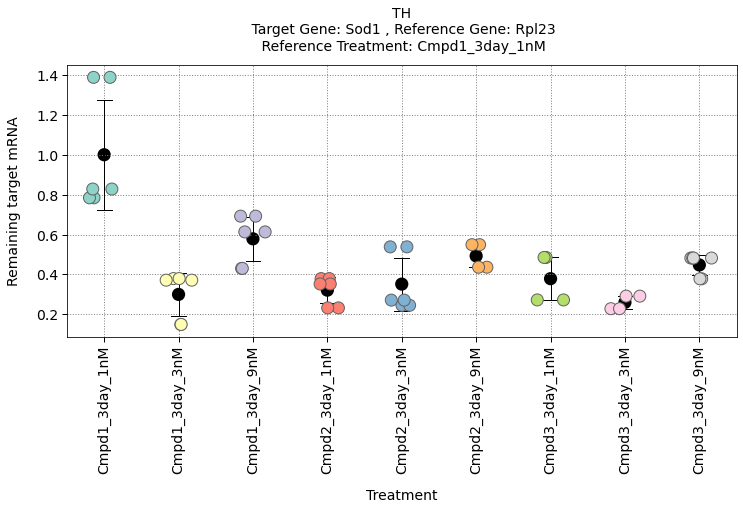

In [26]:
# indicate the "separate" parameter that you want to group/plot your data according to
separate = 'Tissue'
separate_idx_df3 = df3.columns.get_loc(separate)
unique_separate = df3.iloc[:, separate_idx_df3].unique()
num_separate = len(unique_separate)

for n in range(num_separate):
    df4 = df3[df3[separate] == unique_separate[n]]

    # now sort df4 by Treatment and the sorted df is df4
    df4 = df4.sort_values(by = ['Treatment', 'SampleId'], ascending = [True, True])
    df4 = df4.reset_index()
     
    # calculate average expression of reference group
    ref_group_rows = df4.index[df4.Treatment == reference_treatment].tolist()
    expression_ref_group = df4['AvgExpression'].iloc[ref_group_rows].mean(axis=0)
    # add RelativeExpression column to df4
    df4['RelativeExpression'] = df4['AvgExpression']/expression_ref_group
      
    # calculate relative expression of each sample to reference group
    # then calculate the mean and standard deviation of each group
    # and save it to GroupExpression and GroupExpressionStdev
    unique_treatment_df4 = df4.Treatment.unique()
    
    for g in range(len(unique_treatment_df4)):    
        treatment_rows = df4.index[df4.Treatment == unique_treatment_df4[g]].tolist()
        treatment_relative_expression = df4['RelativeExpression'].iloc[treatment_rows].mean(axis=0)
        treatment_relative_expression_stdev = df4['RelativeExpression'].iloc[treatment_rows].std(axis=0)    
        df4.loc[treatment_rows, 'TreatmentExpression'] = treatment_relative_expression
        df4.loc[treatment_rows, 'TreatmentExpressionStdev'] = treatment_relative_expression_stdev
       
    df4 = df4.round(decimals = 3)
    final_result = 'qPCR_analysis_summary_'
    df4.to_excel(path + final_result + unique_separate[n] + '.xlsx', 
                 columns = ['WellId', 'Tissue', 'Group', 'Compound', 'Dose', 'Duration', 'Treatment', 'Animal#', 'TechRep',
                            'SampleId', 'Reference','Target', 'DeltaCt', 'Expression 2^-DeltaCt', 'AvgExpression',
                            'RelativeExpression', 'TreatmentExpression', 'TreatmentExpressionStdev',], index = False)
    
    # make a new dataframe for prism
    df_prism = df4
    df_prism['RelativeExpression2'] = df_prism['Expression 2^-DeltaCt']/expression_ref_group
    # df_prism['Sample#'] = df_prism['Sample'].str[-2:]
    df_prism = df_prism.round(decimals = 3)
    df_prism = df_prism.sort_values(by = ['Treatment', 'SampleId'], ascending = [True, True])
    df_prism_wide = pd.pivot(df_prism, index = 'Animal#', columns = ['Treatment', 'TechRep'] , values = 'RelativeExpression2')
    
    # save final df into csv file
    # final_result = 'qPCR_analysis_summary_'
    # df4.to_excel(path + final_result + unique_separate[n] + '.xlsx', index = False)
    df_prism_wide.to_excel(path + final_result + unique_separate[n]  + '_prism.xlsx', index = True)
    
    # now plot the analysis result

    fig = plt.figure(facecolor='white', figsize=(12,5))

    ax = sns.stripplot(data=df4, x='Treatment', y='RelativeExpression', jitter=0.2, size = 12, palette = "Set3", linewidth=1)
    ax = sns.pointplot(data=df4, x='Treatment', y='RelativeExpression', ci="sd", color = 'black', markers='o',
                 join=False, capsize = 0.2, scale = 1.5, errwidth = 1)
    #ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Treatment', color = 'black', fontsize=14, labelpad=15)
    ax.set_ylabel('Remaining target mRNA', color='black', fontsize=14, labelpad=15)
    ax.tick_params('both', labelsize=14, length=5, width=1, which='major', )
    ax.tick_params(axis='x', labelrotation=90)

    plt.grid(color='grey', linestyle=':', linewidth=1)

    ax.set_title(unique_separate[n] + '\n Target Gene: ' + target_gene + ' , Reference Gene: ' + ref_gene + '\n Reference Treatment: ' 
             + reference_treatment, fontsize = 14, pad = 15)

    fig.savefig(path + '/qPCR_graph_' + unique_separate[n] + '.eps', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True )
    fig.savefig(path + '/qPCR_graph_' + unique_separate[n] + '.png', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False )

In [ ]:
from scipy.stats import f_oneway
f_oneway(performance1, performance2, performance3, performance4)